In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from celltypist import models
import celltypist
# Load the .h5ad file
adata = sc.read_h5ad("All_subset.h5ad")

In [2]:
adata_celltypist = adata.copy()  # make a copy of our adata
adata_celltypist.X = adata.layers["counts"]  # set adata.X to raw counts
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()

In [3]:
#pip install celltypist

In [4]:

models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 52
📂 Storing models in C:\Users\25258\.celltypist\data\models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [5]:
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")
adata_celltypist = adata_celltypist[np.random.choice(adata_celltypist.shape[0], size=5000, replace=False)]


In [6]:
model_high.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

In [7]:
model_low.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

In [8]:
# from celltypist import annotate
# import anndata as ad
# import pandas as pd

# batch_size = 2000
# all_predictions = []

# # Loop through the data in batches
# for i in range(0, adata_celltypist.n_obs, batch_size):
#     batch = adata_celltypist[i:i + batch_size].copy()
#     predictions_batch = annotate(batch, model="Immune_All_High.pkl", majority_voting=True)
#     all_predictions.append(predictions_batch.predicted_labels)
#     print(f"Processed batch {i // batch_size + 1}")

In [9]:
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)

🔬 Input data has 5000 cells and 51734 genes
🔗 Matching reference genes in the model
🧬 6450 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
c:\Users\25258\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [10]:
predictions_high_adata = predictions_high.to_adata()

In [12]:
# adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
#     adata.obs.index, "majority_voting"
# ]
# adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
#     adata.obs.index, "conf_score"
# ]

adata.obs["celltypist_cell_label_coarse"] = predictions_high.adata.obs["majority_voting"].reindex(adata.obs.index)
adata.obs["celltypist_conf_score_coarse"] = predictions_high.adata.obs["conf_score"].reindex(adata.obs.index)


In [13]:
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)

🔬 Input data has 5000 cells and 51734 genes
🔗 Matching reference genes in the model
🧬 6450 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [14]:
predictions_low_adata = predictions_low.to_adata()

In [23]:
adata.obs["celltypist_cell_label_fine"] = predictions_low.adata.obs["majority_voting"].reindex(adata.obs.index)
adata.obs["celltypist_conf_score_fine"] = predictions_low.adata.obs["conf_score"].reindex(adata.obs.index)

In [24]:
# Run PCA first if not done already
sc.tl.pca(adata)

# Compute the neighborhood graph for UMAP
sc.pp.neighbors(adata)

# Run UMAP embedding
sc.tl.umap(adata)
print("X_umap" in adata.obsm)  # Should return True after computation


True


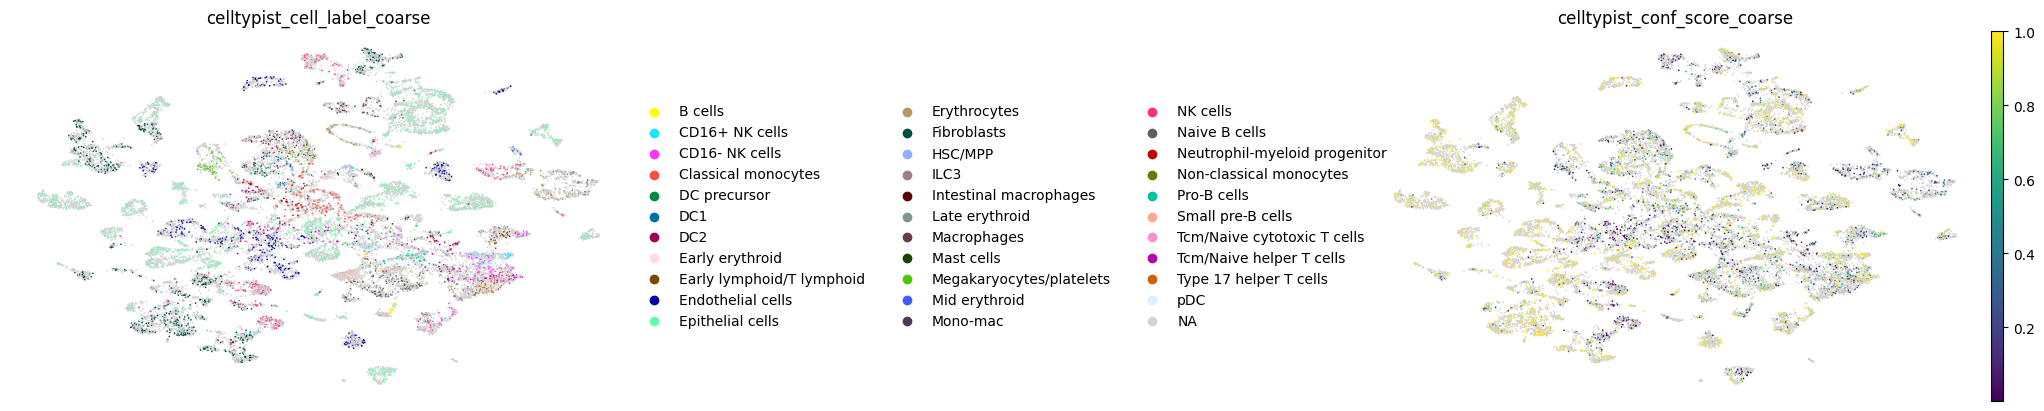

In [19]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse", "celltypist_conf_score_coarse"],
    frameon=False,
    sort_order=False,
    wspace=1,
)

In [21]:
print(adata.obs.columns)


Index(['sample_id', 'batch', 'developmental_stage', 'site', 'gender',
       'donor_id', 'platform', 'dataset', 'unit',
       'celltypist_cell_label_coarse', 'celltypist_conf_score_coarse'],
      dtype='object')


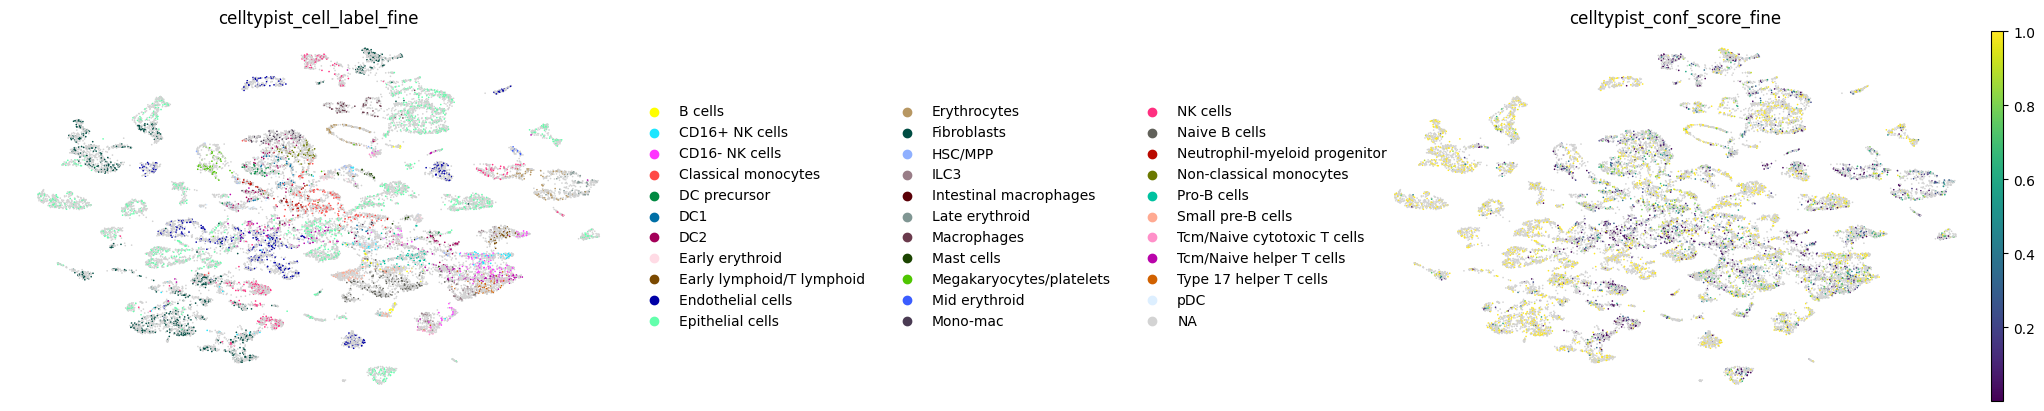

In [26]:

sc.pl.umap(
    adata,
    color=["celltypist_cell_label_fine", "celltypist_conf_score_fine"],
    frameon=False,
    sort_order=False,
    wspace=1,
)

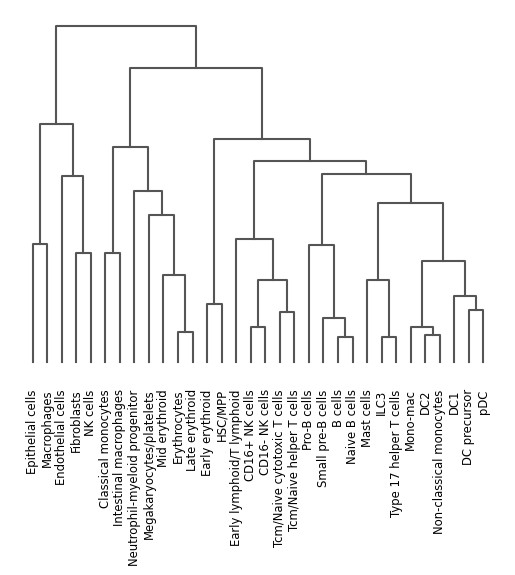

<Axes: >

In [27]:
sc.pl.dendrogram(adata, groupby="celltypist_cell_label_fine")

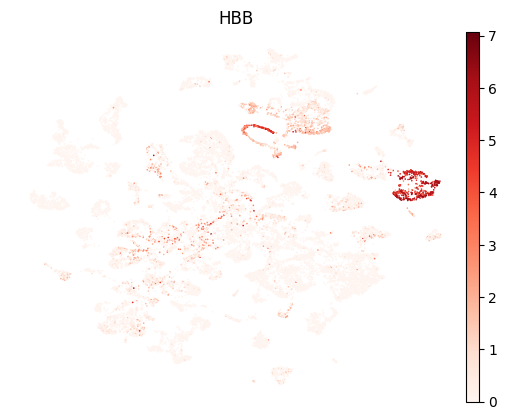

In [30]:
sc.pl.umap(adata, color="HBB", cmap="Reds", frameon=False, sort_order=False)